#**Files Setup**

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 14.24 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


##**Create Function for Model Feature extractor**

In [2]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
  # Create EffnetB2 pretrained weights and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # Freeze all the layers in base model
  for params in model.parameters():
    params.require_grads = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_classes)
  )

  return model, transforms

In [3]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 77.7MB/s]


In [4]:
summary(effnetb2_food101,
        input_size = (1, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [5]:
# Create Training Data Transforms
food_101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

In [6]:
food_101_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [7]:
# Create Testing data transforms
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

##**Getting FoodVision Dataset**
https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html

In [8]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path('data')

# Get the training data
train_data = datasets.Food101(root = data_dir,
                              split = 'train',
                              transform = food_101_transforms,
                              download = True)

test_data = datasets.Food101(root = data_dir,
                             split = 'test',
                             transform = effnetb2_transforms,
                             download = True)

100%|██████████| 4996278331/4996278331 [05:11<00:00, 16054917.22it/s]


Extracting data/food-101.tar.gz to data


In [9]:
# Get Food101 Class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

##**Creating a subset of the Food101 dataset**

In [10]:
len(train_data) * 0.2, len(test_data) * 0.2

(15150.0, 5050.0)

In [11]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float = 0.2,
                  seed: int = 42):
  # Create split lengths
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out Info
  print(f'[INFO] Splitting dataset of length: {len(dataset)} into splits of size: {length_1} and {length_2}')

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths = [length_1, length_2],
                                                                 generator = torch.manual_seed(seed))

  return random_split_1, random_split_2

In [12]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset = train_data,
                                              split_size = 0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset = test_data,
                                             split_size = 0.2)


[INFO] Splitting dataset of length: 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length: 25250 into splits of size: 5050 and 20200


In [13]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

##**Turning Food101 datasets into DataLoaders**

In [14]:
import torch

NUM_WORKERS = 2

BATCH_SIZE = 32

# Create Food101 20% training dataloader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset = train_data_food101_20_percent,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle = True,
                                                                  num_workers = NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset = test_data_food101_20_percent,
                                                                 batch_size = BATCH_SIZE,
                                                                 shuffle = False,
                                                                 num_workers = NUM_WORKERS)

In [15]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

##**Training FoodVision**

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params = effnetb2_food101.parameters(),
                             lr = 1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(model = effnetb2_food101,
                                        train_dataloader = train_dataloader_food101_20_percent,
                                        test_dataloader = test_dataloader_food101_20_percent,
                                        optimizer = optimizer,
                                        loss_fn = loss_fn,
                                        epochs = 5,
                                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1050 | train_acc: 0.3413 | test_loss: 2.1936 | test_acc: 0.5787
Epoch: 2 | train_loss: 2.2676 | train_acc: 0.5670 | test_loss: 1.9255 | test_acc: 0.6667
Epoch: 3 | train_loss: 1.9890 | train_acc: 0.6486 | test_loss: 1.8109 | test_acc: 0.6999
Epoch: 4 | train_loss: 1.8013 | train_acc: 0.7081 | test_loss: 1.7808 | test_acc: 0.7100
Epoch: 5 | train_loss: 1.6769 | train_acc: 0.7479 | test_loss: 1.7376 | test_acc: 0.7246


##**Inspecting Loss curves of FoodVision model**

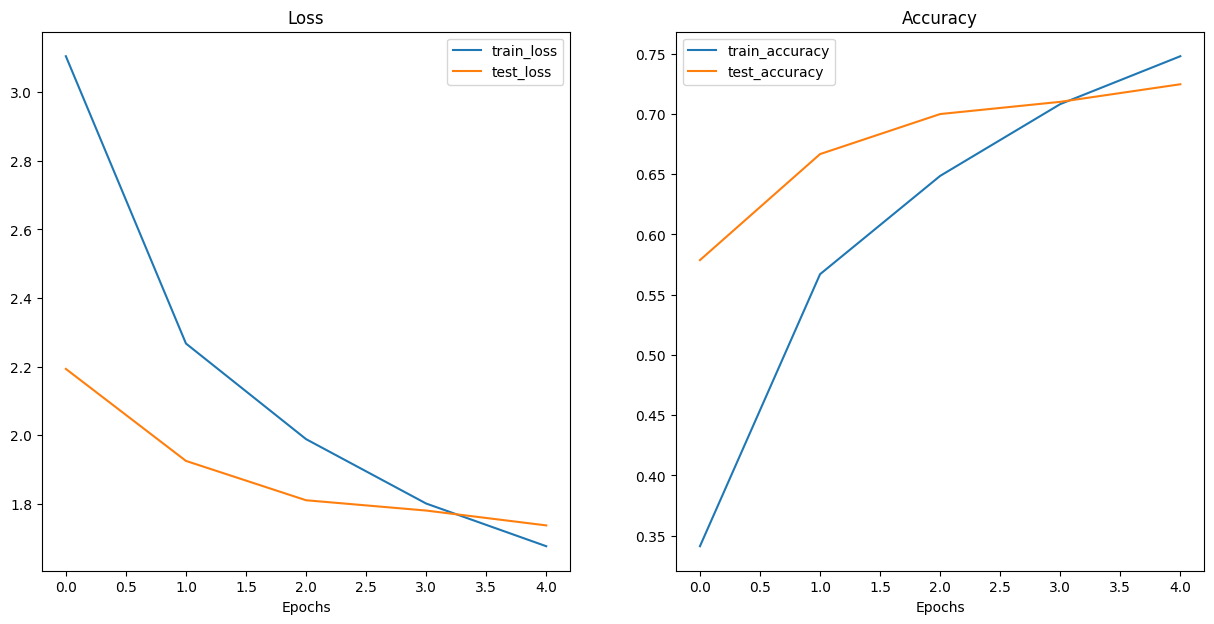

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

##**Save and load the FoodVision Model**

In [19]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = 'effnetb2_Food101.pth'

# Save the model
utils.save_model(model = effnetb2_food101, target_dir = 'models/',
                 model_name = effnetb2_food101_model_path)

[INFO] Saving model to: models/effnetb2_Food101.pth


In [20]:
# Load the model
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

loaded_effnetb2_food101.load_state_dict(torch.load('models/effnetb2_Food101.pth'))

<All keys matched successfully>

##**Checking Model size**

In [21]:
from pathlib import Path

# Get the model size in bytes and then convert it to Megabytes
effnetb2_model_size = Path('models/effnetb2_Food101.pth').stat().st_size / (1024 * 1024)
print(f'Pretrained EffNetB2 Feature Extractor model size: {round(effnetb2_model_size)} MB')

Pretrained EffNetB2 Feature Extractor model size: 30 MB


##**Creating deployable app**

In [22]:
from pathlib import Path

# Create Foodvision demo path
foodvision_demo_path = Path('demos/foodvision')

# Make Foodvision directory
foodvision_demo_path.mkdir(parents = True,
                           exist_ok = True)

# Make Foodvision Big Demo examples directory
(foodvision_demo_path / 'examples').mkdir(parents = True, exist_ok = True)

In [23]:
!ls demos/foodvision/

examples


In [24]:
!mv /content/models/effnetb2_Food101.pth demos/foodvision

##**Creating `class_names.txt`**

In [25]:
# Create path to Food101 Class names
foodvision_class_names_path = foodvision_demo_path/ 'class_names.txt'
foodvision_class_names_path

PosixPath('demos/foodvision/class_names.txt')

In [26]:
# Write Food101 class names to text file
with open(foodvision_class_names_path, 'w') as f:
  print(f'[INFO] Saving Food101 class names to {foodvision_class_names_path}')
  f.write('\n'.join(food101_class_names)) # New line per class name

[INFO] Saving Food101 class names to demos/foodvision/class_names.txt


In [27]:
# Open Food101 class names files and read each line into a list
with open(foodvision_class_names_path, 'r') as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [28]:
%%writefile demos/foodvision/model.py

import torch
import torchvision
from torch import nn

from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
  # Create EffnetB2 pretrained weights and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # Freeze all the layers in base model
  for params in model.parameters():
    params.require_grads = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_classes)
  )

  return model, transforms

Writing demos/foodvision/model.py


##**Gradio App**

In [29]:
!pip install -U pip
!pip install -U httpcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.5 MB/s eta 0:00:00


In [30]:
## 1. Imports and Class names setup
!pip install gradio
import gradio as gr

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.9 MB/s eta 0:00:00
   

ImportError: ignored

In [31]:
%%writefile demos/foodvision/app.py

### 1. Imports and class names setup###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open('class_names.txt', 'r') as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 101)

# Load saved weights
effnetb2.load_state_dict(
  torch.load(f = 'effnetb2_Food101.pth',
              map_location = torch.device('cpu'))
)

### 3. Predict Function ###
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with effnetb2
  img = effnet_b2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediction label and prediction probability dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description and article
title = 'FoodVision 🍔🍕🍰👁'
description = 'An EfficientNetB2 Feature extractor'
article = 'Pytorch model deployment'

# Create example list
example_list = [['1.jpg'],
                ['2.jpg'],
                ['3.jpg'],
                ['4.jpg'],
                ['5.jpg']]

# Create gradio demo
demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type = 'pil'),
                    outputs = [gr.Label(num_top_classes = 5, label = 'Predictions'),
                               gr.Number(label = 'Prediction time (s)')],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

demo.launch(debug = False)

Writing demos/foodvision/app.py


In [32]:
%%writefile demos/foodvision/requirements.txt
torch==2.1.0
torchvision==0.16.0
gradio==4.7.1

Writing demos/foodvision/requirements.txt


##**Zip the folder and download it**

In [33]:
!cd demos/foodvision && zip -r ../foodvision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 56%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_Food101.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: model.py (deflated 52%)
  adding: requirements.txt (deflated 4%)


In [34]:
## Download
try:
  from google.colab import files
  files.download('demos/foodvision.zip')
except:
  print(f'Not running in Google colab, please download manully.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>